<h1><center>Predictive Analytics on Imbalanced Data</center></h1>
<h2><center>Group 2: Olha Maslova, Mark Morrissey, Qiao Li, Renyin Zhang, April Yang</center></h2>

## Step 0: Set up the environment
First, make sure you have python installed. 

In [ ]:
!python --version

If you don't have python installed - please follow this [link](https://realpython.com/installing-python/) for instructions.

Running the cell below will start the installation of required python libraries, assuming you have python already installed. 

In [ ]:
!pip install scipy
!pip install matplotlib 
!pip install imbalanced-learn
!pip install pandas
!pip install numpy
!pip install opencv-python
!pip install -U scikit-learn
!pip install --upgrade tensorflow
!pip install Keras
!pip install imbalanced-databases
!pip install smote-variants
!pip install xgboost

Setting up working directories.

In [5]:
# path = "C:/Users/liqia/Spring2021-Project3-group-3-master"
# train_dir = "C:/Users/liqia/Spring2021-Project3-group-3-master/data//train_set"

train_dir = 'data/train_set/'
image_dir = train_dir + "images/"
pt_dir = train_dir + "points/"
label_path = train_dir + "label.csv"

Import libraries.

**NOTE:** some of our team memebers had issues installing XGBoost. If you experience the same issue, please comment out ```import xgboost as xgb``` line below and set run_xgboost = False. This will ignore the model and should run smoothly. 

In [1]:
from scipy.spatial.distance import pdist
import imbalanced_databases as imbd
import matplotlib.pyplot as plt
import scipy.io as scio
from PIL import Image
import pandas as pd
import numpy as np
import xlsxwriter
import scipy.io
import sklearn
import os, sys
import pickle
import random
import time
import cv2

from sklearn.pipeline import Pipeline
from sklearn.datasets import make_classification
from sklearn.metrics import (classification_report, 
                            confusion_matrix, 
                            recall_score,
                            accuracy_score,
                            make_scorer,
                            roc_auc_score,
                            auc,
                            roc_curve)

from sklearn.model_selection import (train_test_split,
                                    cross_validate, 
                                    GridSearchCV,
                                    RepeatedStratifiedKFold,
                                    cross_val_score,
                                    validation_curve)

# dealing with imbalanced dataset
from imblearn.under_sampling import RandomUnderSampler               
from imblearn.over_sampling import SMOTE

# models
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import (GradientBoostingClassifier, 
                              RandomForestClassifier,
                              AdaBoostClassifier,
                              VotingClassifier)

from sklearn.linear_model import (LogisticRegression, 
                                  RidgeClassifier,
                                  Lasso)

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn import tree
#import xgboost as xgb
from sklearn.neighbors import (KNeighborsClassifier, 
                               NearestCentroid,
                               NeighborhoodComponentsAnalysis)

random.seed(2021)

# for CNN and Neural Networks
import tensorflow as tf
from tensorflow import keras
from keras.regularizers import l2, l1_l2
from tensorflow.keras import layers
from tensorflow.keras import metrics
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator

## Step 1: Set up controls for evaluation experiments

In this chunk, we have a set of controls for model training/testing. If true, then we train the model and generate predictions on the test set, and if false, then we skip that model. By default, only baseline and advanced are set to True.

**NOTE:** Please note, that this notebook contains all pre-run outputs for you to evaluate. You don't need to run all the classifiers. 

In [16]:
run_baseline = True
run_advanced = True

run_nearest_centroid = False
run_knn = False
run_adaboost = False
run_random_forest=False
run_svm = False
run_weighted_svm = False
run_stochastic_gradient_descent = False
run_neural_networks = False
run_cnn = False
run_nn = False
run_decision_tree = False
run_ridge_regression = False
run_voting_classifier = False
run_xgboost = False
run_gaussian_nb = False
run_lasso_regression = False

If you re-trained models you have an option to save them in the output directory.

In [2]:
save = True

fold cross validation with AUC scoring:

In [14]:
run_cv = False

run code to fine-tune models:

In [13]:
fine_tuning = False

## Step 2: Import data and perform train-test split

Fiducial points are stored in matlab format. In this step, we read them and store them in a list.

In [3]:
def read_data(train_dir):      
    # read labels
    labels = pd.read_csv(train_dir+'label.csv')
    y = labels['label'].to_numpy()

    # read points
    n = 3000
    for i in range(1, n + 1):
        p_path = str(i).zfill(4) + '.mat'
        mat = scipy.io.loadmat(train_dir + '/points/' + p_path)
        # pull out the matrix
        if 'faceCoordinatesUnwarped' in mat:
            cords = mat['faceCoordinatesUnwarped'] 
        else:
            cords = mat['faceCoordinates2']
        # find the distance 
        distance = sklearn.metrics.pairwise_distances(cords)       
        flatten_distance = distance[np.triu_indices(len(cords[:,0]), k = 1)]    

        # add distance to an array
        if i == 1:
            distances = np.mat([flatten_distance])
        else:
            distances = np.append(distances, np.mat([flatten_distance]), axis = 0)
    
    return (distances, y)

# now instead of the whole matrix we are dealing with pairwise distance

In [6]:
read_time_start = time.time()
X, Y = read_data(train_dir)

print("Read the original dataset takes %s seconds" % round((time.time() - read_time_start), 3))

Read the original dataset takes 87.188 seconds


In [7]:
print('majority class: %d' % np.sum(Y == 0))
print('minority class: %d' % np.sum(Y == 1))

majority class: 2402
minority class: 598


Train-test split since we can see that the dataset is imbalanced, in this chunk we do an 80-20 train-test split.

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=0, stratify=Y)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((2400, 3003), (2400,), (600, 3003), (600,))

Data Preprocessing Imbalanced Dataset (SMOTE)-oversamplig

In [9]:
def data_preprocessing(X, Y, train_dir):

    distances = X
    y = Y

    n = y.shape[0]
    mat_1 = np.add(np.where(y == 1), 1)
    n_oversample = (n - sum(y)) - sum(y) 

    for i in range(n_oversample):
        samples_index = random.sample(list(list(mat_1)[0]), 2) 
        
        p_path = str(samples_index[0]).zfill(4) + '.mat'
        mat = scipy.io.loadmat(train_dir + '/points/' + p_path)
        
        if 'faceCoordinatesUnwarped' in mat:
            cords_0 = mat['faceCoordinatesUnwarped'] 
        else:
            cords_0 = mat['faceCoordinates2']

        p_path = str(samples_index[1]).zfill(4) + '.mat'
        mat = scipy.io.loadmat(train_dir + '/points/' + p_path)
        
        if 'faceCoordinatesUnwarped' in mat:
            cords_1 = mat['faceCoordinatesUnwarped'] 
        else:
            cords_1 = mat['faceCoordinates2']

        cords_new = (cords_0 + cords_1) / 2 
        
        # compute the pairwise distances in each mat
        distance = sklearn.metrics.pairwise_distances(cords_new)
        
        # stretch the upper triangle of the symmetric matrix 
        # to a long array with dimension 3003
        # 3003 = (1+77) * 78/2
        flatten_distance = distance[np.triu_indices(len(cords_new[:,0]), k = 1)]
        
        distances = np.append(distances, np.mat([flatten_distance]), axis = 0)
        
        y = np.append(y, np.array(1))
            
    return (distances, y)

In [10]:
X_train, y_train = data_preprocessing(X_train, y_train, train_dir)

In [11]:
X_train.shape, y_train.shape

((3844, 3003), (3844,))

Here we define functions to visualise confusion matrix and call the model

## Step 3: Construct a baseline Gradient Boosting Model

In [26]:
# define the model
def train_model_gb(X, y):
    model_gb = GradientBoostingClassifier(n_estimators=100)
    model_gb.fit(X, y)
    
    return model_gb

In [28]:
def fine_tune_gbm():
    param_range = [10, 50, 100, 200, 300, 400]
    train_scores, valid_scores = validation_curve(
        model_gb, 
        X = X_train, 
        y=y_train, 
        param_name='n_estimators',
        param_range=param_range
    )
    
    # compute means and std
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    val_scores_mean = np.mean(valid_scores, axis=1)
    val_scores_std = np.std(valid_scores, axis=1)
    
    plt.title("Validation Curve with GBM")
    plt.xlabel("n_estimators")
    plt.ylabel("Score")
    plt.ylim(0.01, 1)
    lw = 2
    plt.semilogx(param_range, train_scores_mean, label="Training score",
                 color="darkorange", lw=lw)
    plt.fill_between(param_range, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.2,
                     color="darkorange", lw=lw)
    plt.semilogx(param_range, val_scores_mean, label="Cross-validation score",
                 color="navy", lw=lw)
    plt.fill_between(param_range, val_scores_mean - val_scores_std,
                     val_scores_mean + val_scores_std, alpha=0.2,
                     color="navy", lw=lw)
    plt.legend(loc="best")
    plt.show()
    
if fine_tuning:
    fine_tune_gbm()

#### Step 3.1 Train the baseline model and evaluate on imbalanced test set

In [30]:
# train the model
if run_baseline:
    training_gbm = time.time()
    model_gb = train_model_gb(X_train, y_train)

    print("Train the Gradient Boosting Model takes %s seconds" % round((time.time() - training_gbm), 3))

    y_pred = model_gb.predict(X_test)

    # print the confusion matrix
    print(confusion_matrix(y_true=y_test, y_pred=y_pred))
    print(classification_report(y_true=y_test, y_pred=y_pred))
    
    # save model
    if save:
        pickle.dump(model_gb, open( path + "/output/baseline.p",'wb'))
          
else:
    # load model
    pickle.load(open(path + "/output/baseline.p",'rb'))

Train the Gradient Boosting Model takes 299.138 seconds
[[348 132]
 [ 66  54]]
              precision    recall  f1-score   support

           0       0.84      0.72      0.78       480
           1       0.29      0.45      0.35       120

    accuracy                           0.67       600
   macro avg       0.57      0.59      0.57       600
weighted avg       0.73      0.67      0.69       600



#### Step 3.2 Evaluate baseline model on Balanced dataset using Undersampling

To properly evaluate our model, we are performing undersampling to have a balanced dataset. 

In [31]:
under = RandomUnderSampler()

In [32]:
# fit and apply the transform
X_test_1, y_test_1 = under.fit_resample(X_test, y_test)

In [33]:
start = time.time()
y_pred_1 = model_gb.predict(X_test_1)
end = time.time()

print("Predicting test data takes %s seconds" % round((end - start), 3))

Predicting test data takes 0.007 seconds


In [34]:
y_pred_prob = model_gb.predict_proba(X_test_1)[:,1]
print('AUC is: {:.4f}'.format(roc_auc_score(y_test_1, y_pred_prob)))

AUC is: 0.6675


In [35]:
# print the confusion matrix
print(confusion_matrix(y_true=y_test_1, y_pred=y_pred_1))
print(classification_report(y_true=y_test_1, y_pred=y_pred_1))

[[90 30]
 [66 54]]
              precision    recall  f1-score   support

           0       0.58      0.75      0.65       120
           1       0.64      0.45      0.53       120

    accuracy                           0.60       240
   macro avg       0.61      0.60      0.59       240
weighted avg       0.61      0.60      0.59       240



### Step 4: Build and Evaluate Advanced Model: Weighted SVM

In [36]:
def fine_tune_svm():
    weighted_svm = SVC(gamma = 'scale', class_weight = 'balanced')

    #CV Weighted SVM 
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    # evaluate model
    scores = cross_val_score(weighted_svm, X_train, y_train, scoring='roc_auc', cv=cv, n_jobs=-1)
    # summarize performance
    print('Mean ROC AUC: %.3f' % np.mean(scores))

    # parameter space for the model
    param_grid = {
        'C': [0.1, 1, 10, 100, 1000],
        'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
        'kernel': ['rbf']} 

    grid_svm = GridSearchCV(SVC(), param_grid, refit=True, verbose=3)
    grid_svm.fit(X_train,y_train)
    
    print(grid_svm.best_params_)
    print(grid_svm.best_estimator_)
    
    balance = [{0:598.0, 1:2402.0},{0:1,1:100}, {0:1,1:10}, {0:1,1:1}, {0:10,1:1}, {0:100,1:1}]
    param_grid = dict(class_weight=balance)

    grid_weightedsvm = GridSearchCV(estimator=weighted_svm, param_grid=param_grid, n_jobs=-1, cv=cv, scoring='roc_auc')
    grid_weightedsvm.fit(X_train, y_train)
    grid_weightedsvm.best_params_
    grid_weightedsvm.best_estimator_
    grid_weightedsvm.best_params_
    grid_weightedsvm.best_estimator_
    
    print("Best: %f using %s" % (grid_weightedsvm.best_score_, grid_weightedsvm.best_params_))
    
    # report all configurations
    means = grid_weightedsvm.cv_results_['mean_test_score']
    stds = grid_weightedsvm.cv_results_['std_test_score']
    params = grid_weightedsvm.cv_results_['params']
    
    for mean, stdev, param in zip(means, stds, params):
        print("%f (%f) with: %r" % (mean, stdev, param))

In [37]:
if fine_tuning:
    fine_tune_svm()

Train SVM using best params:
- 'C' = 10
- 'gamma' = 0.0001
- 'kernel' = 'rbf'

In [ ]:
if run_advanced:
    weighted_svm_best = SVC(
        gamma = 'scale',
        class_weight = {
            0: 598.0, 
            1: 2402.0
        },
        probability=True
    )
    
    start_time = time.time()
    
    # fit svm model
    weighted_svm_best.fit(X_train, y_train)
    
    print("Training  model takes %s seconds" % round((time.time() - start_time),3))
    print('Testing Accuracy of weighted SVM on test set: {:.3f}'
          .format(weighted_svm_best.score(X_test,y_test)))
    
    start = time.time()
    
    # make prediction
    weighted_svm_pred = weighted_svm_best.predict(X_test)
    
    end = time.time()

    weighted_svm_predprob = weighted_svm_best.predict_proba(X_test)[:,1]

    print("Predicting test data takes %s seconds" % round((end - start),3))
    print('Classification error rate:', np.mean(np.array(y_test) != weighted_svm_pred))
    print('Classification report \n', classification_report(y_test, weighted_svm_pred))

    print('Confusion Matrix \n', confusion_matrix(y_test, weighted_svm_pred))
    print('AUC is: {:.4f}'.format(roc_auc_score(y_test, weighted_svm_predprob)))
    
else:
    #Load model
    weighted_svm = pickle.load(open(path + "/output/advanced.p",'rb'))
    
    start = time.time()
    
    weighted_svm_pred = weighted_svm.predict(X_test)
    
    end = time.time()

    weighted_svm_predprob = weighted_svm.predict_proba(X_test)[:,1]

    print("Predicting test data takes %s seconds" % round((end - start),3))
    print('Classification error rate:', np.mean(np.array(y_test) != weighted_svm_pred))
    print('Classification report \n', classification_report(y_test, weighted_svm_pred))

    print('Confusion Matrix \n', confusion_matrix(y_test, weighted_svm_pred))
    print('AUC is: {:.4f}'.format(roc_auc_score(y_test, weighted_svm_predprob)))

#Save Advanced Model
if save:
    pickle.dump(weighted_svm_best, open( path + "/output/advanced.p",'wb'))

Training  model takes 98.393 seconds
Testing Accuracy of weighted SVM on test set: 0.575
Predicting test data takes 2.97 seconds
Classification error rate: 0.425
Classification report 
               precision    recall  f1-score   support

           0       0.87      0.55      0.67       480
           1       0.27      0.68      0.39       120

    accuracy                           0.57       600
   macro avg       0.57      0.62      0.53       600
weighted avg       0.75      0.57      0.62       600

Confusion Matrix 
 [[263 217]
 [ 38  82]]
AUC is: 0.6893


<h1><center>Alternative Model Options</center></h1>

In the section below we present models that we tried, but didn't select as our advanced model.

<h2><center>Nearest Centroid</center></h2>

In [23]:
if run_nearest_centroid:
    clf = NearestCentroid()
    
    start_time=time.time()
    clf.fit(X_train, y_train)
    
    NearestCentroid()
    print("Training  model takes %s seconds" % round((time.time() - start_time),3))

    start = time.time()
    y_pred=clf.predict(X_test)
    end = time.time()
    
    print("Predicting test data takes %s seconds" % round((end - start), 3))
    print(classification_report(y_test, y_pred))
    
    fpr, tpr, thresholds = roc_curve(y_test, y_pred, pos_label=1)
    print('AUC is', auc(fpr, tpr))
    
    # Save Model
    if save:
        pickle.dump(clf, open("output/nearest_centroid.p",'wb'))

Training  model takes 0.045 seconds
Predicting test data takes 0.005 seconds
              precision    recall  f1-score   support

           0       0.78      0.48      0.59       480
           1       0.19      0.47      0.27       120

    accuracy                           0.48       600
   macro avg       0.48      0.48      0.43       600
weighted avg       0.66      0.48      0.53       600

AUC is 0.4760416666666667


<h2><center>K Neighbors Classifier</center></h2>

In [21]:
if fine_tuning:
    for k in range(3, 10):
        nca = NeighborhoodComponentsAnalysis(random_state = 42)
        knn = KNeighborsClassifier(n_neighbors = k)
        
        nca_pipe = Pipeline([('nca', nca), ('knn', knn)])
        nca_pipe.fit(X_train, y_train)
        pre=nca_pipe.predict(X_test)
        
        print('the score of a model with k = %d is %f' % (k, nca_pipe.score(X_test, y_test)))
        print('the recall of a model with k = %d is %f' % (k, recall_score(y_test, pre)))
    
if run_knn:
    # based on fine tuning above k = 3 is the best value
    k = 3
    
    nca = NeighborhoodComponentsAnalysis(random_state=42)
    knn = KNeighborsClassifier(n_neighbors=k)
    
    nca_pipe = Pipeline([('nca', nca), ('knn', knn)])
    
    start_time=time.time()

    nca_pipe.fit(X_train, y_train)
    
    print("Training  model takes %s seconds" % round((time.time() - start_time),3))

    start_time=time.time()
    y_pred = nca_pipe.predict(X_test)
    print("Predicting test data takes %s seconds" % round((time.time() - start_time), 3))
    
    print('The score of a model with k = %d is %f' % (k, nca_pipe.score(X_test, y_test)))
    print('The recall of a model with k = %d is %f' % (k, recall_score(y_test, y_pred)))
    print(classification_report(y_test, y_pred))
    
    fpr, tpr, thresholds = roc_curve(y_test, y_pred, pos_label=1)
    print('AUC is', auc(fpr, tpr))
    
    #Save Model
    if save:
        pickle.dump(nca_pipe, open("output/knn.p",'wb'))

Training  model takes 24.813 seconds
Predicting test data takes 0.172 seconds
The score of a model with k = 3 is 0.475000
The recall of a model with k = 3 is 0.666667
              precision    recall  f1-score   support

           0       0.84      0.43      0.57       480
           1       0.23      0.67      0.34       120

    accuracy                           0.48       600
   macro avg       0.53      0.55      0.45       600
weighted avg       0.71      0.47      0.52       600

AUC is 0.546875


<h2><center>Stochastic Gradient Descent</center></h2>

In [25]:
if run_stochastic_gradient_descent:
    clf = SGDClassifier(loss="log", penalty="l1", max_iter=200, shuffle=True, class_weight='balanced')
    
    start_time=time.time()
    clf.fit(X_train, y_train)
    print("Training  model takes %s seconds" % round((time.time() - start_time),3))

    start = time.time()
    y_pred=clf.predict(X_test)
    end = time.time()
    
    print("Predicting test data takes %s seconds" % round((end - start),3))
    print(classification_report(y_test, y_pred))
    
    fpr, tpr, thresholds = roc_curve(y_test, y_pred, pos_label=1)
    print('AUC is', auc(fpr, tpr))
    
    #Save Model
    if save:
        pickle.dump(clf, open("output/SGDClassifier.p",'wb'))

Training  model takes 6.924 seconds
Predicting test data takes 0.002 seconds
              precision    recall  f1-score   support

           0       0.89      0.25      0.40       480
           1       0.23      0.88      0.36       120

    accuracy                           0.38       600
   macro avg       0.56      0.56      0.38       600
weighted avg       0.76      0.38      0.39       600

AUC is 0.5645833333333333


<h2><center>Decision Trees</center></h2>

In [26]:
if run_decision_tree:
    clf = DecisionTreeClassifier(
        max_depth = 30,
        min_samples_leaf=2,
        max_leaf_nodes=3,
        class_weight='balanced'
    )
    
    start_time=time.time()
    clf = clf.fit(X_train, y_train)
    print("Training  model takes %s seconds" % round((time.time() - start_time),3))

    start = time.time()
    y_pred = clf.predict(X_test)
    end = time.time()
    
    print("Predicting test data takes %s seconds" % round((end - start),3))
    print(classification_report(y_test, y_pred))
    
    fpr, tpr, thresholds = roc_curve(y_test, y_pred, pos_label=1)
    print('AUC is', auc(fpr, tpr))
    
    #Save Model
    if save:
        pickle.dump(clf, open("output/DecisionTree.p",'wb'))

Training  model takes 3.249 seconds
Predicting test data takes 0.003 seconds
              precision    recall  f1-score   support

           0       0.88      0.31      0.46       480
           1       0.23      0.83      0.36       120

    accuracy                           0.41       600
   macro avg       0.56      0.57      0.41       600
weighted avg       0.75      0.41      0.44       600

AUC is 0.571875


<h2><center>Random Forest</center></h2>

In [27]:
if run_random_forest:
    clf = RandomForestClassifier(
        n_estimators=300,
        class_weight='balanced'
    )
    
    start_time=time.time()
    clf = clf.fit(X_train, y_train)
    print("Training  model takes %s seconds" % round((time.time() - start_time), 3))

    start = time.time()
    y_pred=clf.predict(X_test)
    end = time.time()
    
    print("Predicting test data takes %s seconds" % round((end - start), 3))
    print(classification_report(y_test, y_pred))
    
    fpr, tpr, thresholds = roc_curve(y_test, y_pred, pos_label=1)
    print('AUC is', auc(fpr, tpr))
    
    #Save Model
    if save:
        pickle.dump(clf, open("output/RandomForest.p",'wb'))

Training  model takes 57.554 seconds
Predicting test data takes 0.067 seconds
              precision    recall  f1-score   support

           0       0.84      0.81      0.83       480
           1       0.33      0.38      0.35       120

    accuracy                           0.73       600
   macro avg       0.59      0.59      0.59       600
weighted avg       0.74      0.72      0.73       600

AUC is 0.59375


<h2><center>AdaBoost</center></h2>

In [28]:
if run_adaboost:
    clf = AdaBoostClassifier(n_estimators=200)
    
    start_time=time.time()
    clf = clf.fit(X_train, y_train)
    print("Training  model takes %s seconds" % round((time.time() - start_time),3))

    start_time=time.time()
    y_pred=clf.predict(X_test)
    end = time.time()
    
    print("Predicting test data takes %s seconds" % round((end - start),3))
    print(classification_report(y_test, y_pred))
    
    fpr, tpr, thresholds = roc_curve(y_test, y_pred, pos_label=1)
    print('AUC is', auc(fpr, tpr))
    
    # save Model
    if save:
        pickle.dump(clf, open("output/AdaBoost.p",'wb'))

Training  model takes 219.452 seconds
Predicting test data takes 220.132 seconds
              precision    recall  f1-score   support

           0       0.85      0.75      0.80       480
           1       0.32      0.48      0.39       120

    accuracy                           0.69       600
   macro avg       0.59      0.61      0.59       600
weighted avg       0.75      0.69      0.71       600

AUC is 0.6145833333333333


<h2><center>XGBoost</center></h2>

In [ ]:
if run_xgboost:
    param_dist = {'objective':'binary:logistic', 'n_estimators':2}
    clf = xgb.XGBClassifier(**param_dist)
    start_time=time.time()
    clf = clf.fit(X_train, y_train)
    print("Training  model takes %s seconds" % round((time.time() - start_time),3))

    start_time=time.time()
    y_pred=clf.predict(X_test)
    end = time.time()
    
    print("Predicting test data takes %s seconds" % round((end - start_time),3))
    print(classification_report(y_test, y_pred))
    
    fpr, tpr, thresholds = roc_curve(y_test, y_pred, pos_label=1)
    print('AUC is', auc(fpr, tpr))
    
    # save Model
    if save:
        pickle.dump(clf, open("output/xgboost.p",'wb'))

<h2><center>Ridge Regression</center></h2>

In [30]:
if run_ridge_regression:
    
    clf = RidgeClassifier()
    start_time=time.time()
    clf = clf.fit(X_train, y_train)
    print("Training  model takes %s seconds" % round((time.time() - start_time),3))

    start_time=time.time()
    y_pred=clf.predict(X_test)
    end = time.time()
    
    print("Predicting test data takes %s seconds" % round((end - start_time),3))
    print(classification_report(y_test, y_pred))
    
    fpr, tpr, thresholds = roc_curve(y_test, y_pred, pos_label=1)
    print('AUC is', auc(fpr, tpr))
    
    # save Model
    if save:
        pickle.dump(clf, open("output/Ridge.p",'wb'))

Training  model takes 0.556 seconds
Predicting test data takes 0.002 seconds
              precision    recall  f1-score   support

           0       0.86      0.76      0.81       480
           1       0.34      0.49      0.40       120

    accuracy                           0.71       600
   macro avg       0.60      0.63      0.61       600
weighted avg       0.75      0.71      0.73       600

AUC is 0.628125


<h2><center>Gaussian Naive Bayes</center></h2>

In [31]:
if run_gaussian_nb:
    
    clf = GaussianNB()
    start_time=time.time()
    clf = clf.fit(X_train, y_train)
    print("Training  model takes %s seconds" % round((time.time() - start_time),3))

    start_time=time.time()
    y_pred=clf.predict(X_test)
    end = time.time()
    
    print("Predicting test data takes %s seconds" % round((end - start_time),3))
    print(classification_report(y_test, y_pred))
    
    fpr, tpr, thresholds = roc_curve(y_test, y_pred, pos_label=1)
    print('AUC is', auc(fpr, tpr))
    
    #Save Model
    if save:
        pickle.dump(clf, open("output/GaussianNB.p",'wb'))

Training  model takes 0.161 seconds
Predicting test data takes 0.026 seconds
              precision    recall  f1-score   support

           0       0.82      0.45      0.59       480
           1       0.22      0.61      0.32       120

    accuracy                           0.48       600
   macro avg       0.52      0.53      0.45       600
weighted avg       0.70      0.48      0.53       600

AUC is 0.53125


<h2><center>Lasso Regression</center></h2>

In [32]:
if run_lasso_regression:
    
    clf = Lasso(alpha=0.1)
    start_time=time.time()
    clf = clf.fit(X_train, y_train)
    print("Training  model takes %s seconds" % round((time.time() - start_time),3))

    start_time=time.time()
    y_pred=clf.predict(X_test)
    end = time.time()
    
    print("Predicting test data takes %s seconds" % round((end - start_time),3))
    
    y_pred_adjusted = []
    for pred in y_pred:
        if pred>=0.5:
            y_pred_adjusted.append(1)
        else: y_pred_adjusted.append(0)
            
    y_pred_adjusted = np.asarray(y_pred_adjusted)
    
    print(classification_report(y_test, y_pred_adjusted))
    
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_adjusted, pos_label=1)
    print('AUC is', auc(fpr, tpr))
    
    # save Model
    if save:
        pickle.dump(clf, open("output/Lasso.p",'wb'))

Training  model takes 6.689 seconds
Predicting test data takes 0.002 seconds
              precision    recall  f1-score   support

           0       0.88      0.60      0.72       480
           1       0.30      0.68      0.42       120

    accuracy                           0.62       600
   macro avg       0.59      0.64      0.57       600
weighted avg       0.77      0.62      0.66       600

AUC is 0.6427083333333333


<h2><center>Voting Ensemble Classifier(3 models)</center></h2>

**Note:** Training this classifier will take a while (~20-25 mins). 

In [66]:
if not run_voting_classifier:
    # create three classifiers
    clf1 = LogisticRegression(
        penalty='l2',
        max_iter=10000,
        fit_intercept=True,
        solver='newton-cg',
        tol=10
    )
    clf2 = SVC(C=1, gamma=.001, kernel='linear', probability=False)
    clf3 = GaussianNB()

    # create a voting classifier
    eclf2 = VotingClassifier(estimators=[
      ('lr', clf1), ('dt', clf2), ('gnb', clf3)],
      voting='hard')
    
    # fit voting classifier
    start_time=time.time()
    clf = eclf2.fit(X_train, y_train)
    print("Training model takes %s seconds" % round((time.time() - start_time),3))

    # predict voting classifier
    start_time=time.time()
    y_pred = clf.predict(X_test)
    end = time.time()
    
    # evaluate voting classifier
    print("Predicting test data takes %s seconds" % round((end - start_time),3))
    print(classification_report(y_test, y_pred))
    
    fpr, tpr, thresholds = roc_curve(y_test, y_pred, pos_label=1)
    print('AUC is', auc(fpr, tpr))

    # Save Model
    if save:
        pickle.dump(clf, open("output/voting_classifier.p",'wb'))   

Training model takes 1307.98 seconds
Predicting test data takes 0.914 seconds
              precision    recall  f1-score   support

           0       0.87      0.80      0.83       480
           1       0.39      0.51      0.44       120

    accuracy                           0.74       600
   macro avg       0.63      0.65      0.63       600
weighted avg       0.77      0.74      0.75       600

AUC is 0.6531249999999998


<h2><center>Neural Network</center></h2>

In [75]:
# define a function to plot results of neural network
def plot_nn(history):
    tp = history.history['tp']
    val_tp = history.history['val_tp']

    rc = history.history['recall']
    val_rc = history.history['val_recall']

    pr = history.history['precision']
    val_pr = history.history['val_precision']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    tp = history.history['tp']
    val_tp = history.history['val_tp']

    tn = history.history['tn']
    val_tn = history.history['val_tn']

    fp = history.history['fp']
    val_fp = history.history['val_fp']

    fn = history.history['fn']
    val_fn = history.history['val_fn']

    epochs_range = range(len(history.history['tp']))

    plt.figure(figsize=(20, 8))

    plt.subplot(1, 3, 1)
    plt.plot(epochs_range, pr, label='Training Precision')
    plt.plot(epochs_range, val_pr, label='Validation Precision')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Precision')

    plt.subplot(1, 3, 2)
    plt.plot(epochs_range, rc, label='Training Recall')
    plt.plot(epochs_range, val_rc, label='Validation Recall')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Recall')

    plt.subplot(1, 3, 3)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')

    plt.show()
    plt.figure(figsize=(20, 8))

    plt.subplot(2, 4, 1)
    plt.plot(epochs_range, tp, label='True Positive')
    plt.plot(epochs_range, val_tp, label='Validation True Positive')
    plt.legend(loc='lower right')
    plt.title('Training and Validation True Positive')

    plt.subplot(2, 4, 2)
    plt.plot(epochs_range, tn, label='True Negative')
    plt.plot(epochs_range, val_tn, label='Validation True Negative')
    plt.legend(loc='lower right')
    plt.title('Training and Validation True Negative')

    plt.subplot(2, 4, 3)
    plt.plot(epochs_range, fp, label='False Positive')
    plt.plot(epochs_range, val_fp, label='Validation False Positive')
    plt.legend(loc='upper right')
    plt.title('Training and Validation False Positive')

    plt.subplot(2, 4, 4)
    plt.plot(epochs_range, fn, label='False Negative')
    plt.plot(epochs_range, val_fn, label='Validation False Negative')
    plt.legend(loc='upper right')
    plt.title('Training and Validation False Negative')

    plt.show()

In [70]:
# split train data into train and validation
X_train_nn, X_val_nn, y_train_nn, y_val_nn = train_test_split(
    X_train, 
    y_train, 
    test_size=0.2, 
    random_state=0, 
    stratify=y_train
)

In [ ]:
# Here, we define metrics to be used when training the Neural Network# 
METRICS = [
    keras.metrics.TruePositives(name='tp'),
    keras.metrics.FalsePositives(name='fp'),
    keras.metrics.TrueNegatives(name='tn'),
    keras.metrics.FalseNegatives(name='fn'), 
    keras.metrics.BinaryAccuracy(name='accuracy'),
    keras.metrics.Precision(name='precision'),
    keras.metrics.Recall(name='recall'),
    keras.metrics.AUC(name='auc'),
]

EPOCHS = 100

# Early stopping will ensure that the model doesn't overfit the data
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_auc', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

history = None

# run the model
if run_nn: 
    checkpoint_path = "saved_model/cp.ckpt"
    cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                     save_weights_only=True,
                                                     verbose=1)
    model_nn = Sequential([
            layers.BatchNormalization(),
            layers.Dense(512, activation='relu', kernel_regularizer=l2(1e-5)),
            layers.Dropout(0.2),
            layers.Dense(256, activation='relu', kernel_regularizer=l1_l2(l1=1e-06, l2=0.0001)),
            layers.Dropout(0.2),
            layers.Dense(128, activation='relu'),
            layers.Dropout(0.2),
            layers.Dense(1, activation='sigmoid'),
        ])

    model_nn.compile(optimizer='adamax',
                  loss=tf.keras.losses.BinaryCrossentropy(),
                  metrics=METRICS)
    
    # train the model
    start = time.time()
    history = model_nn.fit(
        X_train_nn, y_train_nn,
        validation_data=(X_val_nn, y_val_nn),
        epochs=EPOCHS,
        callbacks=[early_stopping, cp_callback],
        verbose=0
    )
    print("Training  model takes %s seconds" % round((time.time() - start_time),3))
    
    # make predictions
    scores = []
    y_pred = []
    
    start = time.time()
    predictions = model_nn.predict(X_test)
    
    # convert probabilities to classes
    for pred in predictions:

        if pred > 0.5:
            y_pred.append(1)
        else:
            y_pred.append(0)
            
    print("Predicting test data takes %s seconds" % round((end - start), 3))

    print(confusion_matrix(y_true=y_test, y_pred=y_pred))
    print(classification_report(y_true=y_test, y_pred=y_pred))
    
    # save model
    if save:
        model_nn.save('/output/nn.h5')
    
else:
    # load trained model
    model_nn = tf.keras.models.load_model('saved_model/nn.h5', compile=False)
    model_nn.compile(optimizer='adamax',
                  loss=tf.keras.losses.BinaryCrossentropy(),
                  metrics=METRICS)

    model_nn.evaluate(X_test, y_test)

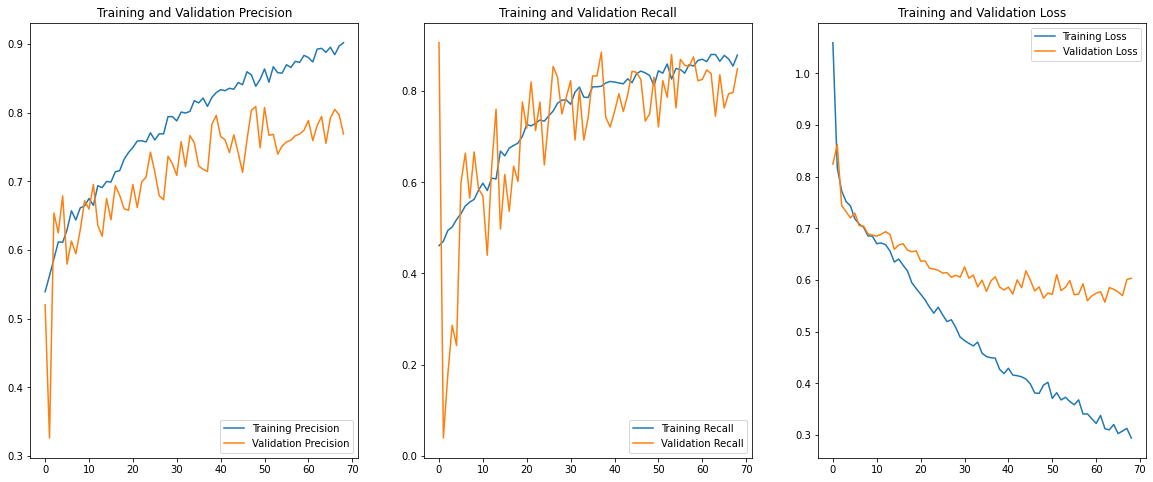

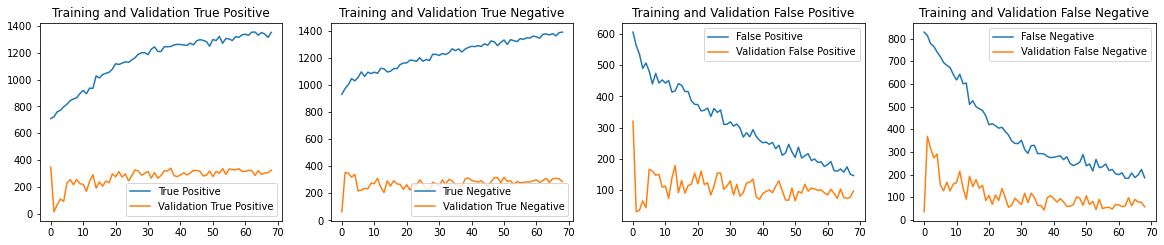

In [76]:
if model_nn:
    plot_nn(history)